In [5]:
#Setup
import numpy as np
from numpy.testing import assert_almost_equal
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib.pyplot as plt 


## Part 0 - Setup

In [136]:
### Constants
sigma1 = 0.11
sigma2 = 0.13
T = 1.7
mu = 0.13
r = 0.01
S0 = 149
time_break = 0.3
K = 188
KH = S0
n_sims = 1_000
n_steps = 300

In [137]:
### Helper Functions

### Time-varying vol

def time_varying_vol(t):
    if t > time_break:
        return sigma1 + sigma2 * (t - time_break)/(T - time_break)
    return sigma1

assert_almost_equal(np.array([time_varying_vol(0.2), time_varying_vol(0.4), time_varying_vol(0.5), time_varying_vol(T)]) ,
                    np.array([sigma1, 0.11928571428, 0.128571429, sigma1 + sigma2]))

def integrate_vol(start_time = 0, end_time = T):
    squared_vol = lambda x: time_varying_vol(x) ** 2
    result = integrate.quad(squared_vol, start_time, end_time)
    return result[0]

assert_almost_equal(np.array([integrate_vol(end_time = 0.3), integrate_vol(0, 1), integrate_vol(0, 1.7)]),
                    np.array([0.3 * 0.11 ** 2, 0.018090833333, 0.0484766666]))

### Black-Scholes

def get_d1_and_d2(S, t, K, T, r, sigma):
    tau = T - t
    d1 = 1/(sigma * np.sqrt(tau)) * (np.log(S/K) + (r + sigma ** 2 / 2) * tau)    
    d2 = d1 - sigma * np.sqrt(tau)
    return d1, d2


def black_scholes_call_price(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put_price(S,t, K,T,r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return  K * np.exp(-r * T) * norm.cdf( -d2) - S * norm.cdf(-d1) 

def black_scholes_call_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.cdf(d1)

def black_scholes_put_delta(S, t, K, T, r,sigma):
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return -1 * norm.cdf(-1 * d1)

def black_scholes_gamma(S, t, K, T, r,sigma):
    #same for a call and put
    d1, d2 = get_d1_and_d2(S, t, K, T, r, sigma)
    return norm.pdf(d1)/(S * sigma * np.sqrt(T - t))


assert_almost_equal(black_scholes_call_price(100,0,  100, 1, 0.01, 0.2), 8.43332, decimal = 5)
assert_almost_equal(black_scholes_call_delta(100,0, 100, 1, 0.01, 0.2), 0.55962, decimal = 5)
assert_almost_equal(black_scholes_gamma(100,0, 100, 1, 0.01, 0.2), 0.01972, decimal = 5)
assert_almost_equal(black_scholes_put_price(100,0, 100, 1, 0.01, 0.2), 7.43831, decimal = 5)
assert_almost_equal(black_scholes_put_delta(100,0, 100, 1, 0.01, 0.2), -0.44038, decimal = 5)
assert_almost_equal(black_scholes_gamma(100,0, 100, 1, 0.01, 0.2), 0.01972, decimal = 5)


## Q1 - Delta Hedging

In [138]:
### Dummy testing case

def simulate_gbm_paths(S0, mu, sigma, T, n_steps, n_paths):
    rng = np.random.default_rng(seed = 42)
    paths = np.zeros([n_paths, n_steps + 1])
    dt = T / n_steps
    paths[:, 0] = S0
    times = np.linspace(0, T, n_steps + 1)

    epsilon = rng.normal(size = [n_paths, n_steps])

    for i in range(0, n_steps):
        paths[:, i  +1] = paths[:, i] + paths[:, i] * mu * dt + paths[:, i] * sigma * np.sqrt(dt) * epsilon[:, i]

    return paths, times

def call_delta_hedging( S0, K, T, r, mu, sigma, n_steps, n_paths):
    ### BEGIN SOLUTION
    S, times = simulate_gbm_paths(S0,mu,sigma,T,n_steps,n_paths)
    portfolio = np.zeros(S.shape)
    t=times[0]
    V = black_scholes_call_price(S0,0,K,T,r,sigma)
    portfolio[:,0] = V
    dt = T/n_steps #...
    for i in range(0,len(times)-1):
        t = times[i]
        S_t=S[:,i]
        q_t = black_scholes_call_delta(S_t,t,K,T,r,sigma)
        B_t = portfolio[:,i]-q_t*S_t
        B_with_interest = B_t*np.exp(dt*r)
        S_tplusdt=S[:,i+1]
        new_stock_value=q_t*S_tplusdt
        portfolio[:,i+1]=B_with_interest+new_stock_value

    S_T = S[:,-1]
    final_balance = portfolio[:,-1]
    error = final_balance - np.maximum(S_T - K,0)
    return error

S0_dummy = 100
K_dummy = 100
T_dummy = 1
sigma_dummy = 0.2
mu_dummy = 0.08
r_dummy = 0.02
n_steps_dummy = 365
n_paths_dummy = 500

err = call_delta_hedging(S0_dummy, K_dummy, T_dummy, r_dummy, mu_dummy, sigma_dummy, n_steps_dummy, n_paths_dummy)


(array([  3.,   7.,  15.,  45., 143., 183.,  72.,  20.,  10.,   2.]),
 array([-1.40211909, -1.13623939, -0.87035969, -0.60447999, -0.33860029,
        -0.07272059,  0.19315911,  0.45903881,  0.72491851,  0.9907982 ,
         1.2566779 ]),
 <BarContainer object of 10 artists>)

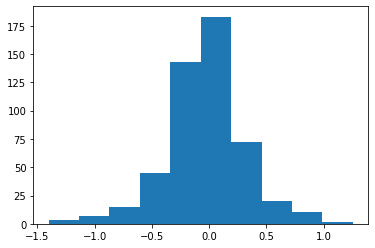

In [139]:
plt.hist(err)

In [146]:
""" def simulate_gbm_paths(S0, mu, sigma, T, n_steps, n_paths):
    rng = np.random.default_rng(seed = 42)
    paths = np.zeros([n_paths, n_steps + 1])
    dt = T / n_steps
    paths[:, 0] = S0
    times = np.linspace(0, T, n_steps + 1)

    epsilon = rng.normal(size = [n_paths, n_steps])

    for i in range(0, n_steps):
        paths[:, i  +1] = paths[:, i] + paths[:, i] * mu * dt + paths[:, i] * sigma * np.sqrt(dt) * epsilon[:, i]

    return paths, times """

def simulate_gbm(S0, mu, T, n_sims, n_steps):
    
    rng = np.random.default_rng(seed = 42)
    paths = np.zeros([n_sims, n_steps + 1])
    dt = T / n_steps
    paths[:, 0] = S0

    times = np.linspace(0, T, n_steps + 1)

    epsilon = rng.normal(size = [n_sims, n_steps])
    
    for i in range(0, n_steps):
        #Euler-Maruyama Scheme
        paths[:, i + 1] = paths[:, i] + paths[:, i] * mu * dt + paths[:, i] * time_varying_vol(times[i]) * np.sqrt(dt) * epsilon[:, i]
                                               
    return paths, times

""" def call_delta_hedging( S0, K, T, r, mu, sigma, n_steps, n_paths):
    ### BEGIN SOLUTION
    S, times = simulate_gbm_paths(S0,mu,sigma,T,n_steps,n_paths)
    portfolio = np.zeros(S.shape)
    t=times[0]
    V = black_scholes_call_price(S0,0,K,T,r,sigma)
    portfolio[:,0] = V
    dt = T/n_steps #...
    for i in range(0,len(times)-1):
        t = times[i]
        S_t=S[:,i]
        q_t = black_scholes_call_delta(S_t,t,K,T,r,sigma)
        B_t = portfolio[:,i]-q_t*S_t
        B_with_interest = B_t*np.exp(dt*r)
        S_tplusdt=S[:,i+1]
        new_stock_value=q_t*S_tplusdt
        portfolio[:,i+1]=B_with_interest+new_stock_value

    S_T = S[:,-1]
    final_balance = portfolio[:,-1]
    error = final_balance - np.maximum(S_T - K,0)
    return error """

def simulate_delta_varying_vol(S0, K, T, r, mu, n_sims, n_steps):
    int_vol = np.sqrt(integrate_vol(end_time = T))
    paths, times = simulate_gbm(S0, mu, T, n_sims, n_steps)
    V = black_scholes_call_price(S0, 0, K, 1, r, int_vol)

    portfolio = np.zeros(paths.shape)
    portfolio[:, 0] = V
    t = times[0]
    dt = T / n_steps

    for i in range(0, len(times) - 1):
        t = times[i]
    
        S_at_time_t = paths[:, i]      
        delta_t = black_scholes_call_delta(S_at_time_t, t, K, T, r, int_vol)
        bank_at_t = portfolio[:, i] - delta_t * S_at_time_t 
        bank_at_t_plus_dt = bank_at_t * np.exp(dt * r)
        S_at_t_plus_dt = paths[:, i+1]
        new_stock_value = delta_t * S_at_t_plus_dt
        portfolio[:, i+1] = bank_at_t_plus_dt + new_stock_value

    S_T = paths[:, -1]
    
    final_portfolio = portfolio[:, -1]
    error = final_portfolio - np.maximum(S_T - K, 0)
    return paths, portfolio, error



In [147]:
paths, port, error = simulate_delta_varying_vol(S0, K, T, r, mu, n_sims, n_steps)

(array([  1.,   1.,   6.,  44., 239., 365., 268.,  64.,   9.,   3.]),
 array([-5.99538943, -4.81478849, -3.63418756, -2.45358662, -1.27298569,
        -0.09238475,  1.08821618,  2.26881711,  3.44941805,  4.63001898,
         5.81061992]),
 <BarContainer object of 10 artists>)

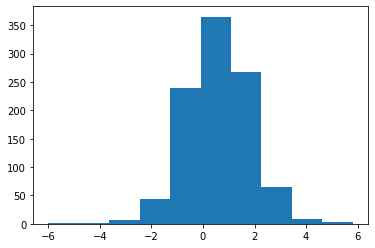

In [148]:
plt.hist(error)